In [2]:
import fastplotlib as fpl
import os
import sys
import masknmf
import tifffile
import torch
import numpy as np

import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Intel(R) Graphics (RPL-P),IntegratedGPU,Vulkan,Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319
❗ limited,"llvmpipe (LLVM 15.0.7, 256 bits)",CPU,Vulkan,Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319 (LLVM 15.0.7)
❌,Mesa Intel(R) Graphics (RPL-P),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 24.2.8-1~bpo12+1pop1~1744225826~22.04~b077665


In [10]:
from pathlib import Path
from tifffile import imread

registered_files =  list(Path("/home/flynn/lbm_data/plane11/reg_tif").glob("*.tif*"))
data = np.concatenate([tifffile.imread(x) for x in registered_files])[:, 100:-100, 100:-100]

In [13]:
mean = np.mean(data, axis = 0)
mean_sub = data - mean

mean.shape, mean_sub.shape

((248, 248), (1437, 248, 248))

In [16]:
import warnings
warnings. filterwarnings('ignore')

iw = fpl.ImageWidget(data=[data.astype(np.float32), mean_sub.astype(np.float32)], names=["reg", "mean-sub"])

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
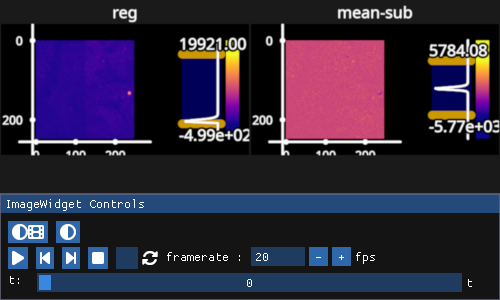

In [15]:
iw.show()

In [19]:
pixel_weighting = torch.from_numpy(np.std(data, axis = 0))

In [21]:
rigid_strategy = masknmf.RigidMotionCorrection(max_shifts = [15, 15], pixel_weighting=pixel_weighting)
pwrigid_strategy = masknmf.motion_correction.compute_template(data,
                                                              rigid_strategy,
                                                              num_iterations_piecewise_rigid = 1,
                                                              pwrigid_strategy = pwrigid_strategy,
                                                              device = "cpu",
                                                              batch_size = 1000)

  0%|                                                                                                                                                                                         | 0/8 [00:00<?, ?it/s]


TypeError: mean() received an invalid combination of arguments - got (tuple, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None)
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


In [39]:
moco_results = masknmf.RegistrationArray(data, pwrigid_strategy, device = "cpu")

In [41]:
dense_moco = moco_results[:]

RFBOutputContext()

/home/flynn/repos/work/masknmf-mbo/.venv/lib/python3.12/site-packages/fastplotlib/graphics/_features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
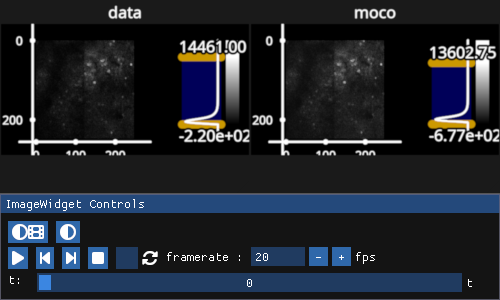

In [42]:
iw = fpl.ImageWidget(data = [data, dense_moco],
                    names = ['data', 'moco'])
iw.cmap = "gray"
iw.show()

In [43]:
iw.close()

In [32]:
np.savez("pmd_reg_subfov.npz", pmd_obj)

In [25]:
pmd_obj = masknmf.compression.pmd_decomposition(data,
                                        [32, 32],
                                        data.shape[0],
                                        max_components = 10,
                                        background_rank = 10,
                                        device = "cpu")

[25-05-02 12:04:29]: Starting compression
[25-05-02 12:04:29]: sampled from the following regions: [0]
[25-05-02 12:04:29]: We are initializing on a total of 5632 frames
[25-05-02 12:04:30]: Approximating full FOV basis terms
[25-05-02 12:04:30]: Loading data to estimate complete spatial basis
[25-05-02 12:04:31]: Finding spatiotemporal roughness thresholds


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:12<00:00, 19.80it/s]

[25-05-02 12:04:43]: Running Blockwise Decompositions


[25-05-02 12:04:50]: Constructed U matrix. Rank of U is 1490
[25-05-02 12:04:51]: PMD Objected constructed


In [29]:
pmd_obj.rescale = False

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
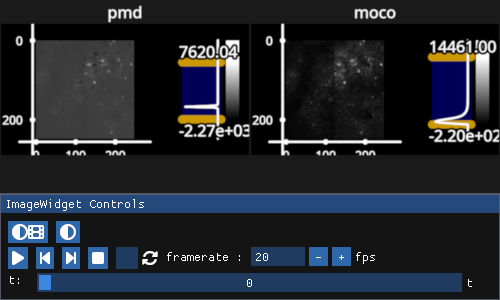

Error during handling key_down event
Traceback (most recent call last):
  File "/home/flynn/repos/work/masknmf-mbo/.venv/lib/python3.12/site-packages/rendercanvas/_coreutils.py", line 41, in log_exception
    yield
  File "/home/flynn/repos/work/masknmf-mbo/.venv/lib/python3.12/site-packages/rendercanvas/_events.py", line 222, in emit
    callback(event)
  File "/home/flynn/repos/work/masknmf-mbo/.venv/lib/python3.12/site-packages/wgpu/utils/imgui/imgui_renderer.py", line 197, in _on_key
    key = ord(key_name.lower())
          ^^^^^^^^^^^^^^^^^^^^^
TypeError: ord() expected a character, but string of length 6 found
Error during handling key_down event: ord() expected a character, but… (2)
Error during handling key_up event: ord() expected a character, but s… (3)
Error during handling key_up event: ord() expected a character, but s… (4)
Error during handling key_down event: ord() expected a character, but… (5)
Error during handling key_down event: ord() expected a character, but… (6)


In [30]:
iw = fpl.ImageWidget(
    data = [pmd_obj, data],
    names = ['pmd', 'moco'],
)
iw.cmap = "gray"
iw.show()

In [45]:
num_frames, fov_dim1, fov_dim2 = pmd_obj.shape
device = 'cpu'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
                                                pmd_obj,
                                                device=device,
                                                frame_batch_size=100)

Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!


/home/flynn/repos/work/masknmf-mbo/masknmf/demixing/regression_update.py:161: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  aTU = torch.sparse.mm(a_sparse.t(), u_sparse)


find pure superpixels!
prepare iteration!


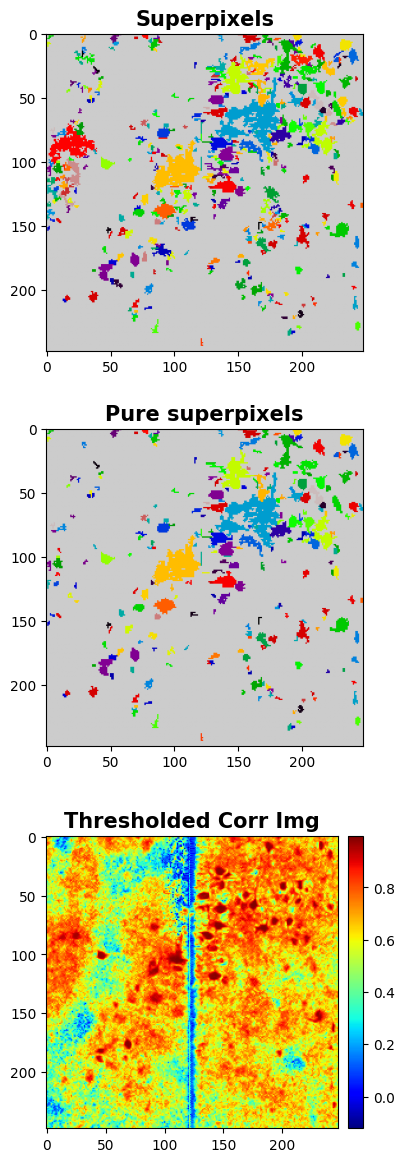

Identified 262 neurons here


In [46]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [49]:
print(pmd_demixer.state.state_description)

Demixing state: Given initial estimates of the signals, this state is designed to run the NMF demixing algorithm to get refined source extractions


In [47]:
pmd_demixer.lock_results_and_continue()

Now in demixing state


 16%|████████████████████████████▏                                                                                                                                                   | 4/25 [00:04<00:26,  1.26s/it]

zero a!
DISPLAYING SOME OF THE COMPONENTS


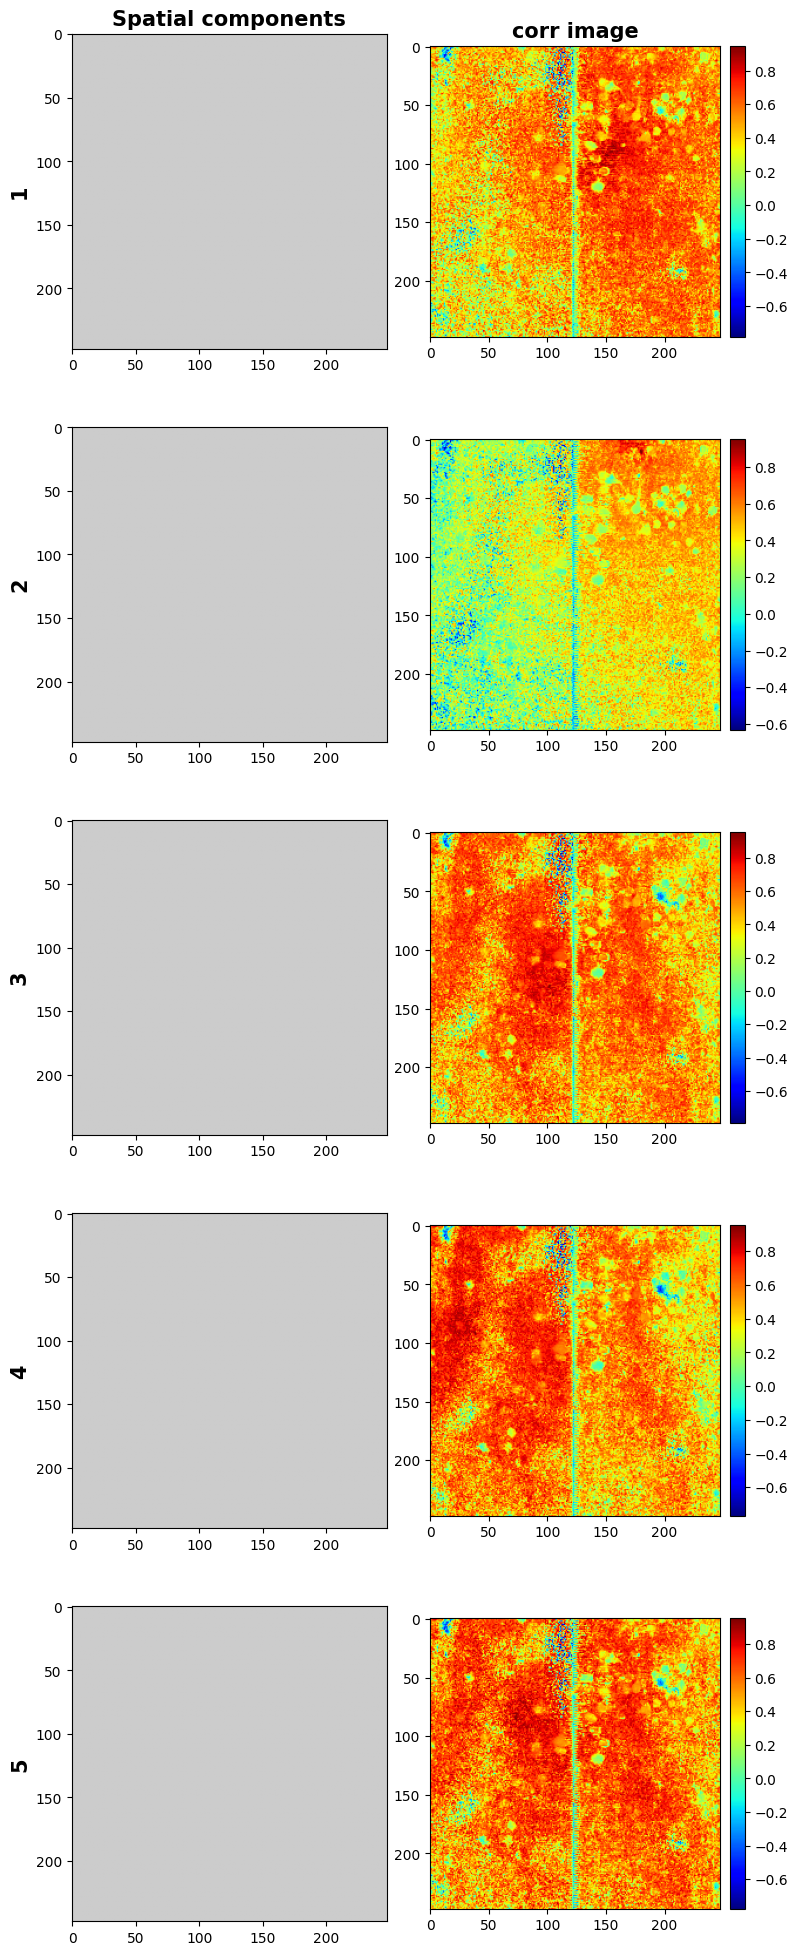

 20%|███████████████████████████████████▏                                                                                                                                            | 5/25 [01:46<10:23, 31.18s/it]

new shape of a is torch.Size([61504, 100])


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                  | 11/25 [12:11<15:30, 66.50s/it]


KeyboardInterrupt: 

In [48]:
## Demixing State

num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")

In [ ]:
# If desired, you can view the demixing results at this stage
iw = masknmf.visualization.make_demixing_video(
    pmd_demixer.results,
    device,
    show_histogram = True,
    v_range = [-100, 300],
)

iw.show()

In [33]:
iw.close()

In [38]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in the initialization state


In [39]:
print(pmd_demixer.state.state_description)

Initialization state: identify initial estimates of the signals present in the data


Computing correlation data structure with MAD threshold  0and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


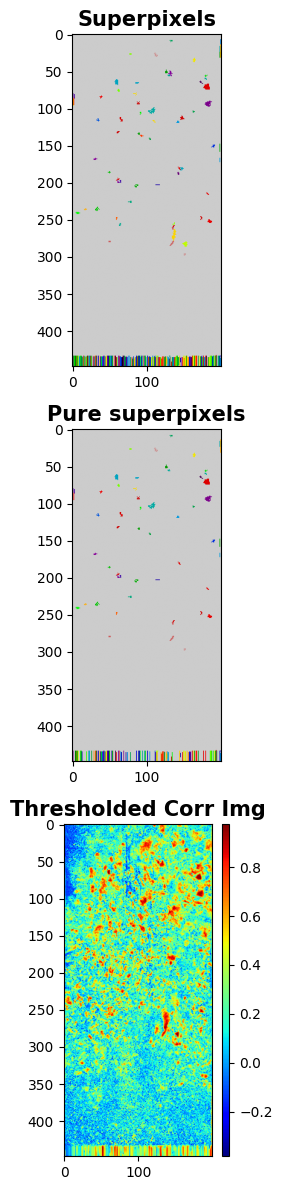

Identified 252 neurons here


In [40]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.9,
    'min_superpixel_size':5,
    'robust_corr_term':1,

    #Mostly stable
    'mad_threshold':0,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [41]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in demixing state


 16%|█████████▍                                                 | 4/25 [00:00<00:03,  6.22it/s]

zero a!
DISPLAYING SOME OF THE COMPONENTS


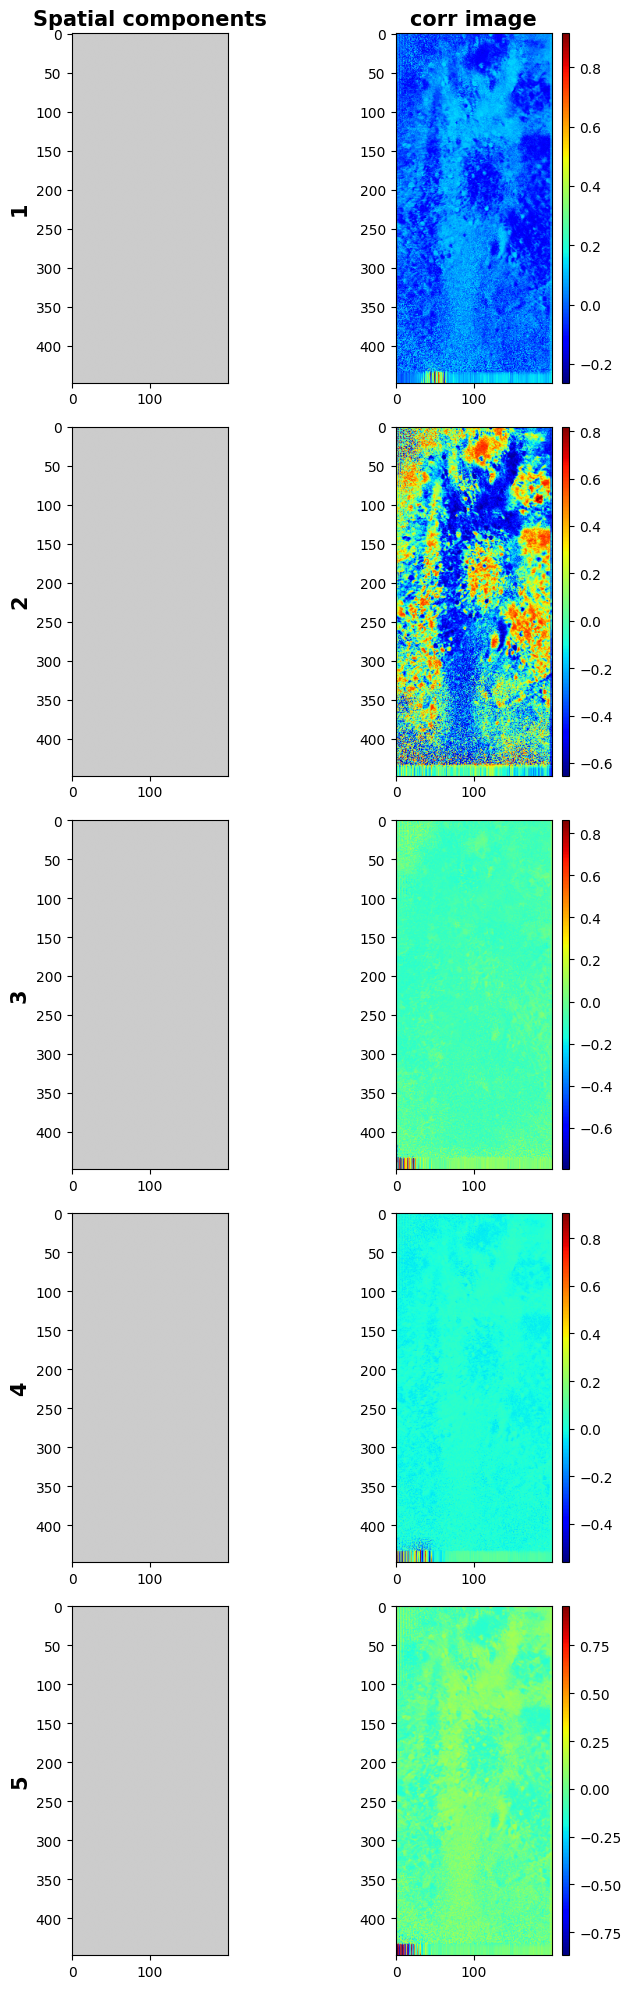

 20%|███████████▊                                               | 5/25 [00:27<02:25,  7.30s/it]

new shape of a is torch.Size([89600, 100])


100%|██████████████████████████████████████████████████████████| 25/25 [09:16<00:00, 22.28s/it]


that took 558.3282947540283
after this step 100 signals identified


In [42]:
## Demixing State
num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



In [43]:
a = pmd_demixer.results.ac_array.export_a()
c = pmd_demixer.results.ac_array.export_c()

#"a" is a fov dim1 x fov dim2 x number of neurons numpy.ndarray
#"c" is a num_frames x num_neurons np.ndarray

In [49]:
np.savez("./pmg_obj.npz", pmd_obj)

In [44]:
c.shape

(64594, 100)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def plot_pmd_projection(proj, a, savepath=None, fig_label=None, vmin=None, vmax=None, add_scalebar=False, dx=2.0):
    """
    Plot PMD projection with ROIs overlaid similarly to Suite2p plot_projection.
    
    Parameters
    ----------
    proj : np.ndarray
        Background image (mean or max projection), shape (Ly, Lx).
    a : np.ndarray
        Spatial components, shape (Ly, Lx, n_rois).
    savepath : Path or None
        Where to save the image (optional).
    fig_label : str or None
        Optional label for the figure.
    vmin, vmax : float
        Contrast limits for the projection.
    add_scalebar : bool
        Add a scale bar to the plot.
    dx : float
        Microns per pixel.
    """
    shape = proj.shape
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')

    vmin = np.nanpercentile(proj, 2) 
    vmax = np.nanpercentile(proj, 98) if vmax is none else vmax
    if vmax - vmin < 1e-6:
        vmax = vmin + 1e-6

    ax.imshow(proj, cmap='gray', vmin=vmin, vmax=vmax)
    masks = np.nanmax(a, axis=-1)
    overlay = np.zeros((*shape, 4), dtype=np.float32)
    overlay[..., 1] = 1 
    overlay[..., 3] = (masks > 0) * 1.0 
    ax.imshow(overlay)

    ax.set_xticks([])
    ax.set_yticks([])
    if fig_label:
        fig_label = fig_label.replace("_", " ").replace("-", " ").replace(".", " ")
        ax.set_ylabel(fig_label, color='white', fontweight='bold', fontsize=12)

    if add_scalebar:
        scale_bar_length = 100 / dx
        scalebar_x = shape[1] * 0.05
        scalebar_y = shape[0] * 0.90
        ax.add_patch(Rectangle((scalebar_x, scalebar_y), scale_bar_length, 5,
                               edgecolor='white', facecolor='white'))
        ax.text(scalebar_x + scale_bar_length / 2, scalebar_y - 10,
                "100 μm", color='white', fontsize=10, ha='center', fontweight='bold')

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    if savepath:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=300, facecolor='black')
        plt.close(fig)
    else:
        plt.show()


In [46]:
mean_img = np.mean(data, axis=0)  # or use a registered mean if available

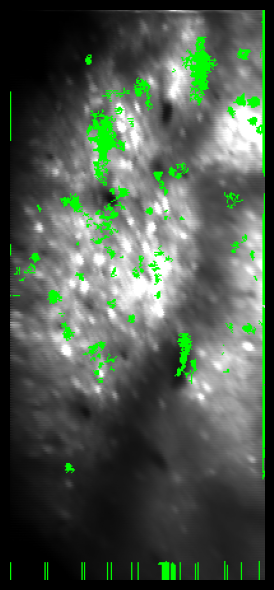

In [48]:
plot_pmd_projection(mean_img, a, dx=2.0)